In [2]:
import matplotlib.pyplot as plt
import numpy as np
import numpy.linalg as la
from functions_parameters.universal_parameters import a, b
from itertools import product

In [3]:
final_result = np.load('u_v1_v2_t_4_em4_random_basis_mesh_60_pmap_over_filling.npz')


final_ground_state_e_diff_density = final_result['gse']
filling_arr = final_result['filling']
final_density = final_result['d']
final_bond = final_result['bond']
final_e_difference = final_result['e_diff']
final_c_difference = final_result['c_diff']
final_e_fermi = final_result['e_fermi']
final_iteration = final_result['iters']
any_bi_fail = final_result['any_bi_fail']

u_arr = final_result['u']
filling_mesh, u_mesh = np.meshgrid(filling_arr, u_arr, indexing = 'ij')

In [4]:
np.max(final_c_difference)

np.float64(0.00013136674935187997)

In [5]:
np.max(final_e_difference)

np.float64(1.4548593840757462e-07)

In [6]:
np.all(any_bi_fail)==False

np.True_

### the convergence is not as good, but probably no need to delete any points right now

## Phase Analysis

In [7]:
sorted_ground_state_e_index = np.argsort(final_ground_state_e_diff_density, axis=2)
sorted_ground_state_e= np.take_along_axis(final_ground_state_e_diff_density, sorted_ground_state_e_index, axis=2)
sorted_density = np.take_along_axis(final_density, sorted_ground_state_e_index[:,:,:,np.newaxis,np.newaxis], axis=2)
sorted_bond = np.take_along_axis(final_bond, sorted_ground_state_e_index[:,:,:,np.newaxis,np.newaxis,np.newaxis,np.newaxis,np.newaxis], axis=2)
sorted_e_fermi = np.take_along_axis(final_e_fermi, sorted_ground_state_e_index, axis=2)
sorted_e_difference = np.take_along_axis(final_e_difference, sorted_ground_state_e_index, axis=2)
sorted_c_difference = np.take_along_axis(final_c_difference, sorted_ground_state_e_index, axis=2)

In [8]:
from functions_parameters.universal_parameters import phase_1_1, threshold, c_6_uc, c_3_uc, c_2_uc
from functions_parameters.tools import phase_check_nematic_magnetic

phase_diagram_based_on_d = np.zeros(filling_mesh.shape)
nematic_measure = np.zeros(filling_mesh.shape)
f_phase = np.zeros(filling_mesh.shape)
f_measure = np.zeros(filling_mesh.shape)
f_max_measure = np.zeros(filling_mesh.shape)
for i in range(filling_mesh.shape[0]):
    for j in range(filling_mesh.shape[1]):
        d_o = sorted_density[i,j,0]
        rs_recording, m_recording, c6_diff, magnetism_arr = phase_check_nematic_magnetic(d_o, c_6_uc, c_3_uc, c_2_uc)
        phase_arr = np.kron(rs_recording,m_recording)
        nematic_measure[i,j] = c6_diff
        f_phase[i,j] = np.argmax(m_recording)
        f_measure[i,j] = np.mean(np.abs(magnetism_arr))
        f_max_measure[i,j] = np.max(np.abs(magnetism_arr))
        phase = np.argmax(phase_arr)
        phase_diagram_based_on_d[i,j]=phase

unique_phase_index = np.unique(phase_diagram_based_on_d)
unique_phase_name = [phase_1_1[i] for i in np.int_(unique_phase_index)]
filtered_phase_diagram = np.zeros(phase_diagram_based_on_d.shape)
for i in range(u_mesh.shape[0]):
    for j in range(u_mesh.shape[1]):
        filtered_phase_diagram[i,j] = np.where(unique_phase_index==phase_diagram_based_on_d[i,j])[0][0]

Text(0.5, 1.0, 'filling = 1')

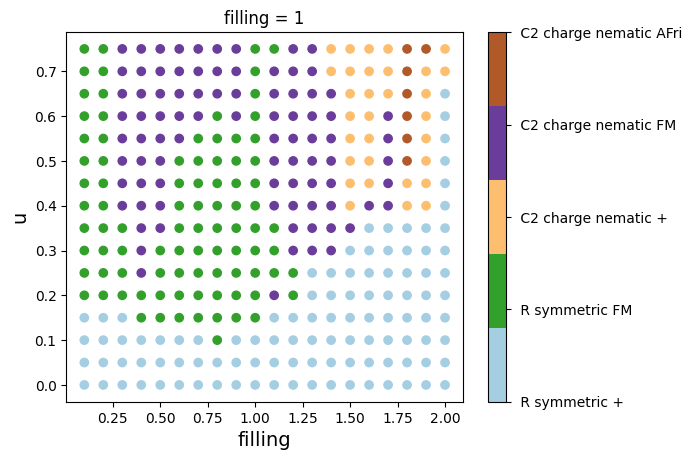

In [9]:
colorbar_ticks_combined = np.arange(len(unique_phase_index))
cmap = plt.get_cmap("Paired", len(unique_phase_index))
# plt.pcolormesh(e_fermi_mesh, u_mesh, phase_diagram_combined_op.T, cmap="Paired")
plt.scatter(filling_mesh, u_mesh, c=filtered_phase_diagram, cmap=cmap)
plt.xlabel('filling', size = '14')
plt.ylabel('u', size = '14')
colorbar_ticks = np.arange(len(unique_phase_index))
cbar = plt.colorbar()
cbar.set_ticks(np.arange(len(unique_phase_index)))
cbar.set_ticklabels(unique_phase_name)
plt.title('filling = 1')

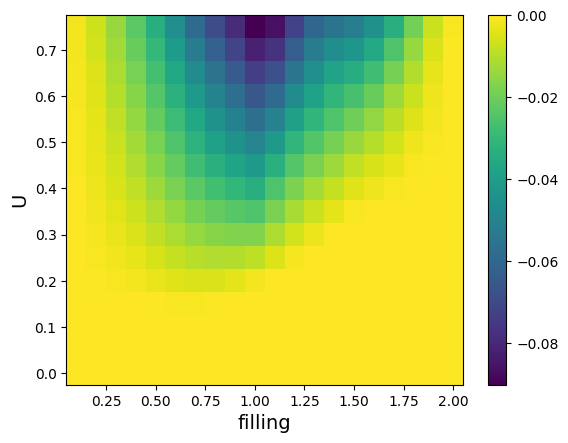

In [10]:
plt.pcolormesh(filling_mesh,u_mesh,sorted_ground_state_e[:,:,0])
plt.xlabel('filling', size = '14')
plt.ylabel('U', size = '14')
plt.colorbar()

### band structure plot

In [11]:
from functions_parameters.universal_parameters import a, b
from functions_parameters.jax_schf_helpers import *
from functions_parameters.bond_table_generator import build_buckets_per_shell
from functions_parameters.jax_schf_kernel import schf_single_job

In [12]:
num_bands = 3
mu = 2
t_nn = 1
t_nnn = -0.025
t_arr = np.array([t_nn, t_nnn])
temperature = 4E-4

# high-symmetry k-path
k_path = np.array([[0, 0],
                   [1 / 2, 0],
                   [1 / 3, 1 / 3],
                   [0, 0],
                   [0, 1 / 2],
                   [-1 / 3, 2 / 3],
                   [0, 0],
                   [-1 / 2, 1 / 2],
                   [-2 / 3, 1 / 3],
                   [0, 0]])
num_k = 30
# obtain the distance of each segment of k path
k_path_distance = [0, la.norm((k_path[1] - k_path[0]) @ b), ]
for i in range(k_path.shape[0] - 2):
    k_path_distance += [
        k_path_distance[-1] + la.norm((k_path[i + 2] - k_path[i + 1]) @ b)]
# obtain the distance for each point along k path for plotting
k_path_line = np.array(
    [np.linspace(k_path_distance[i], k_path_distance[i + 1], num_k) for i in range(len(k_path_distance) - 1)]).reshape(
    (-1))
high_symmetry_k = [k_path_line[num_k * i] for i in range(k_path.shape[0] - 1)]
high_symmetry_k += [k_path_line[-1], ]
# xticks_k = ['G', r'$M_{1}$', r'$K_{1}$', 'G', r'$M_{2}$', r'$K_{2}$', 'G', r'$M_{3}$', r'$K_{3}$', 'G']
xticks_k = ['G', r'$M_{1}$', r'$K_{1}$', 'G', r'$M_{2}$', r'$K_{2}$', 'G', r'$M_{3}$', r'$K_{3}$', 'G']
high_symmetry_spectrum = np.zeros((k_path_line.shape[0], num_bands*2))
k_points_along_path = np.vstack([np.linspace(k_path[i], k_path[i + 1], num_k) for i in range(k_path.shape[0] - 1)])
k_points_along_path = np.array([k @ b for k in k_points_along_path])

In [13]:
filling_index = 9
filling_i = filling_arr[filling_index]/2

In [14]:
filling_i

np.float64(0.5)

In [15]:
basis_frac = np.array([[1/2, 0], [1/2, 1/2], [0, 1/2]])
radii, a_lists, deltas = build_buckets_per_shell(a, basis_frac, 2)

phase_pos_along_path, phase_neg_along_path = precompute_k_phase_tables(deltas, a, k_points_along_path)
Htb_along_path, e_all_along_path, v_all_along_path, v_all_dagger_along_path = hk_all_k_from_phases(mu, a_lists, t_arr, phase_neg_along_path)
# dict_ref = prepare_reference_state(filling_i, a_lists, Htb, e_all, v_all, v_all_dagger, phase_pos, phase_neg, temperature)

u_index = -1
u_input = u_arr[u_index]
v_arr = np.array((u_input, u_input))/2

input_d = sorted_density[filling_index, u_index,0]
input_bond = sorted_bond[filling_index, u_index,0]


In [16]:
from functions_parameters.universal_parameters import a_lists, Htb, e_all, v_all, v_all_dagger, phase_pos, phase_neg, temperature
dict_ref_ref = prepare_reference_state(filling_i, a_lists, Htb, e_all, v_all, v_all_dagger, phase_pos, phase_neg, temperature)
dict_ref_ref['e_fermi']
bond_orders_initial = dict_ref_ref['bond_orders']
density_initial = dict_ref_ref['density_vec']
density_initial = np.stack((density_initial, density_initial))

In [17]:
filling_i

np.float64(0.5)

In [18]:
h_mean_initial_u = mean_field_u(density_initial, u_input)
h_mean_initial_v_o = hartree_spinor(a_lists, v_arr, density_initial)
h_mean_initial_o = h_mean_initial_u + h_mean_initial_v_o
# k-dependent part
h_mean_initial_v_k = np.einsum('Nl,lcmn->Ncnm', phase_pos_along_path, bond_orders_initial)
h_mean_initial_v_k = np.stack((h_mean_initial_v_k, h_mean_initial_v_k), axis=1)
h_mean_initial_v_k = np.einsum('Nsvmn,v->Nsmn', h_mean_initial_v_k, v_arr)
h_mean_initial = h_mean_initial_o[None, :, :, :] - h_mean_initial_v_k
# h_mean_initial = np.zeros((k_points_along_path.shape[0], 2, 3, 3))
# prepare the input mean-field terms
h_mean_input_u = mean_field_u(input_d, u_input)
h_mean_input_v_o = hartree_spinor(a_lists, v_arr, input_d)
h_mean_input_o = h_mean_input_u + h_mean_input_v_o
# k-dependent part
h_mean_input_v_k = fock_spinor(input_bond, v_arr, phase_pos_along_path)
h_mean_input = h_mean_input_o[None, :, :, :] + h_mean_input_v_k
# h_mean_input = h_mean_input_o[None, :, :, :]
# h_mean_input = np.zeros((k_points_along_path.shape[0], 2, 3, 3))

spectrum_nematic = np.zeros((k_points_along_path.shape[0], num_bands*2))
spectrum_original = np.zeros((k_points_along_path.shape[0], num_bands))
for i in range(k_points_along_path.shape[0]):
    e_o, _= la.eigh(Htb_along_path[i])
    spectrum_original[i,:] = e_o
    hup = Htb_along_path[i] + h_mean_input[i,0] - h_mean_initial[i,0]
    e_up,_ = la.eigh(hup)
    hdn = Htb_along_path[i] + h_mean_input[i,1] - h_mean_initial[i,1]
    e_dn,_ = la.eigh(hdn)
    spectrum_nematic[i,:] = np.concatenate((e_up, e_dn))

In [19]:
Htb_along_path[0]

Array([[2.  +0.j, 1.95+0.j, 1.95+0.j],
       [1.95+0.j, 2.  +0.j, 1.95+0.j],
       [1.95+0.j, 1.95+0.j, 2.  +0.j]], dtype=complex128)

In [20]:
la.norm(input_bond[:,1,:,:,:])

np.float64(1.3008791119933012e-43)

In [21]:
bond_orders_initial.shape

(9, 2, 3, 3)

In [22]:
la.norm(bond_orders_initial)

np.float64(0.479648636937728)

In [23]:
la.norm(input_bond[:,0,:,:,:]-bond_orders_initial)

np.float64(0.3028610959071444)

In [24]:
hup - hdn

Array([[-0.24999995+7.55529466e-21j,  0.03816608+2.77376849e-02j,
         0.03816669-2.77376958e-02j],
       [ 0.03816608-2.77376849e-02j, -0.24999979+1.54708359e-20j,
         0.03816648+2.77376919e-02j],
       [ 0.03816669+2.77376958e-02j,  0.03816648-2.77376919e-02j,
        -0.25000025-1.01790090e-19j]], dtype=complex128)

In [25]:
sorted_density[filling_index, u_index,0,0] 

array([0.33333327-1.00737262e-20j, 0.33333306-2.06277812e-20j,
       0.33333367+1.35720120e-19j])

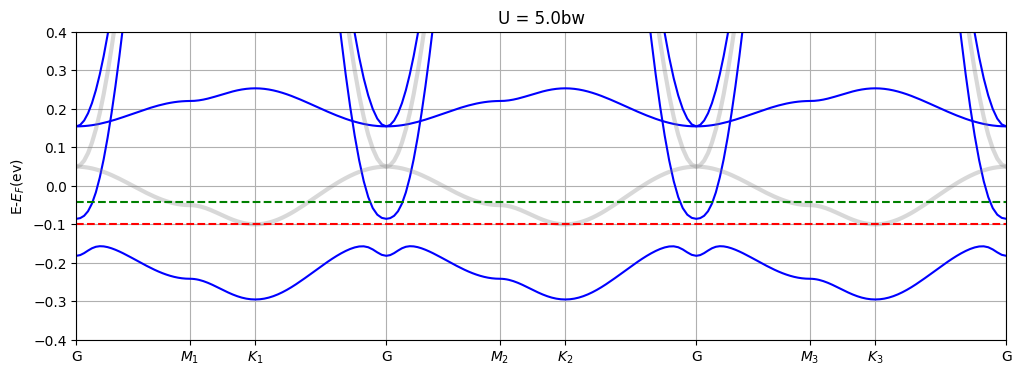

In [26]:
plt.figure(figsize=(12, 4))
plt.plot(k_path_line, spectrum_nematic, 'b-')
plt.plot(k_path_line, spectrum_original, 'grey', alpha = 0.3, linewidth=3)
plt.hlines(dict_ref_ref['e_fermi'], high_symmetry_k[0], high_symmetry_k[-1], colors='green', linestyles='--')
plt.hlines(sorted_e_fermi[filling_index, u_index,0], high_symmetry_k[0], high_symmetry_k[-1], colors='red', linestyles='--')
plt.xlim(high_symmetry_k[0], high_symmetry_k[-1])
plt.ylim(-0.4,0.4)
# plt.ylim(-0.5,0.5)
plt.xticks(high_symmetry_k, xticks_k)
plt.ylabel('E-' + r'$E_{F}$' + '(ev)')
# plt.title(
#     'Band structure of rotated ' + r'$d_{yz}$' + ' and ' + r'$d_{x^{2}-y^{2}}$' + ' with SOC strength %i' % soc_strength)
# plt.ylim(-0.1, 0.04)
plt.title('U = ' + str(u_input/0.15) + 'bw')
plt.grid()

In [27]:
la.norm(spectrum_nematic[:90] - spectrum_nematic[90:180])

np.float64(8.01713047291155e-06)

In [28]:
sorted_e_fermi[filling_index, u_index,0]

np.float64(-0.10003389002441979)

In [29]:
filling_arr[filling_index]

np.float64(1.0)

In [30]:
def n_fold_rotation_2d(n):
    r = np.array([[np.cos(2 * np.pi / n), -np.sin(2 * np.pi / n)],
                  [np.sin(2 * np.pi / n), np.cos(2 * np.pi / n)]])
    return r

In [31]:
from itertools import zip_longest
from scipy.linalg import block_diag
from functions_parameters.tools import fermi_dirac_electron_count

num_grid_per_side = 90
num_grid_per_ray = 90
b2_region_1 = np.linspace(-1 / 3, 1 / 3, num_grid_per_side, endpoint=False)
b1_region_1 = np.array([-x / 2 + 1 / 2 for x in b2_region_1])
point_coef_boundary_region_1 = np.array(list(zip_longest(b1_region_1, b2_region_1)))
# for the sake of plotting the fermi surface we can include all boundary terms
# point_coef_region_1 = np.vstack([np.linspace(v, np.array([0, 0, 0]), num_grid_per_ray, endpoint=False)[1:]
#                                  for v in point_coef_boundary_region_1])
point_coef_region_1 = np.vstack([np.linspace(v, np.array([0, 0]), num_grid_per_ray, endpoint=False)
                                 for v in point_coef_boundary_region_1])
# point_boundary_region_1 = point_coef_boundary_region_1 @ b
point_region_1 = point_coef_region_1 @ b
# rotate the points so that we get all the positive points.
c_6_rotation = n_fold_rotation_2d(6)
c_3_rotation = n_fold_rotation_2d(3)

point_region_2 = np.array([c_6_rotation @ p for p in point_region_1])
point_region_3 = np.array([c_3_rotation @ p for p in point_region_1])
# point_boundary_region_2 = np.array([c_6_rotation @ p for p in point_boundary_region_1])
# point_boundary_region_3 = np.array([c_3_rotation @ p for p in point_boundary_region_1])
point_p_region = np.vstack((point_region_1, point_region_2, point_region_3))
# point_p_region_boundary = np.vstack((point_boundary_region_1, point_boundary_region_2,
#                                      point_boundary_region_3))
# point_all = np.vstack((point_p_region, -point_p_region, point_p_region_boundary, np.array([0, 0, 0])))
point_all = np.vstack((point_p_region, -point_p_region, np.array([0, 0])))
# point_all = np.sort(point_all, axis = 0)
k_point_coef_list = np.array([[1 / 3, 1 / 3],
                              [-1 / 3, 2 / 3],
                              [-2 / 3, 1 / 3],
                              [-1 / 3, -1 / 3],
                              [1 / 3, -2 / 3],
                              [2 / 3, -1 / 3],
                              [1 / 3, 1 / 3]])
k_point_list = k_point_coef_list @ b
sorted_point_all_index = np.lexsort((point_all[:, 1], point_all[:, 0]))
point_all = point_all[sorted_point_all_index]

In [32]:
phase_pos_mesh, phase_neg_mesh = precompute_k_phase_tables(deltas, a, point_all)
Htb_mesh, e_all_mesh, v_all_mesh, v_all_dagger_mesh = hk_all_k_from_phases(mu, a_lists, t_arr, phase_neg_mesh)
dict_ref_mesh = prepare_reference_state(filling_i, a_lists, Htb_mesh, e_all_mesh, v_all_mesh, v_all_dagger_mesh, phase_pos_mesh, phase_neg_mesh, temperature)

# prepare the initial mean-field terms
h_mean_u_mesh = dict_ref_mesh['h_mean_u']
h_mean_v_mesh = dict_ref_mesh['h_mean_v']
h_mean_initial_u_mesh = h_mean_u_mesh*u_input
h_mean_initial_mesh = h_mean_initial_u_mesh[None, :, :, :] + np.einsum('Nsvmn,v->Nsmn', h_mean_v_mesh,v_arr)

# prepare the input mean-field terms
h_mean_input_u_mesh = mean_field_u(input_d, u_input)
h_mean_input_v_o_mesh = hartree_spinor(a_lists, v_arr, input_d)
h_mean_input_o_mesh = h_mean_input_u_mesh + h_mean_input_v_o_mesh
# k-dependent part
h_mean_input_v_k_mesh = fock_spinor(input_bond, v_arr, phase_pos_mesh)
h_mean_input_mesh = h_mean_input_o_mesh[None, :, :, :] + h_mean_input_v_k_mesh

site_distribution = np.zeros((point_all.shape[0], 3))
site_distribution_o = np.zeros((point_all.shape[0], 3))
for i in range(point_all.shape[0]):
    e_o,v_o = la.eigh(Htb_mesh[i])
    site_distribution_o[i,:] =  np.abs(v_o[:,0])**2
    hup = Htb_mesh[i] + h_mean_input_mesh[i,0] - h_mean_initial_mesh[i,0]
    e_up,v_up = la.eigh(hup)
    hdn = Htb_mesh[i] + h_mean_input_mesh[i,1] - h_mean_initial_mesh[i,1]
    e_dn,v_dn = la.eigh(hdn)
    electron_count =  fermi_dirac_electron_count(np.concatenate((e_up, e_dn)), sorted_e_fermi[filling_index, u_index,0], temperature)
    site_distribution[i,:] =  (np.abs(np.concatenate((v_up, v_dn),axis=1)**2))@electron_count


Text(0.5, 1.0, 'site a')

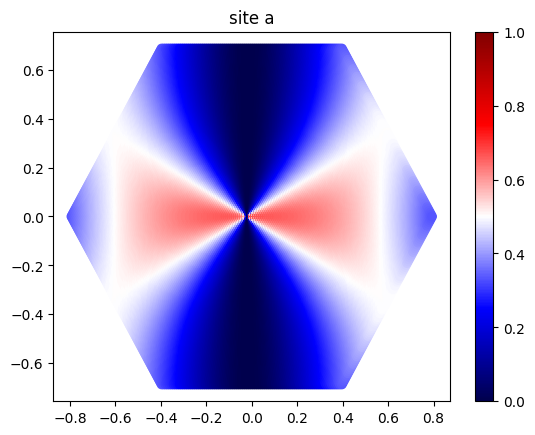

In [33]:
plt.figure()
plt.scatter(point_all[:, 0], point_all[:, 1], c=site_distribution_o[:,0],cmap = 'seismic', vmin=0, vmax=1)
plt.colorbar()
plt.title('site a')

Text(0.5, 1.0, 'site a')

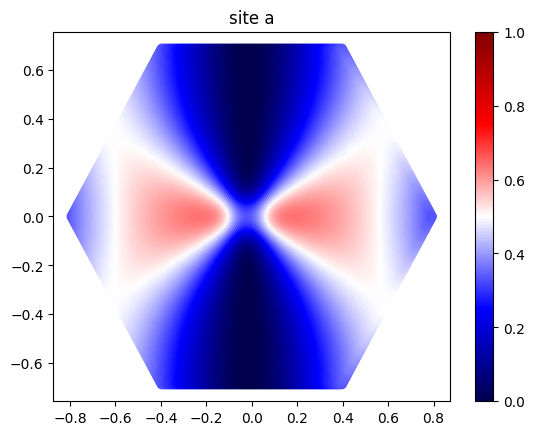

In [34]:
plt.figure()
plt.scatter(point_all[:, 0], point_all[:, 1], c=site_distribution[:,0],cmap = 'seismic', vmin=0, vmax=1)
plt.colorbar()
plt.title('site a')

In [35]:
np.sum(site_distribution,axis=1)

array([1., 1., 1., ..., 1., 1., 1.], shape=(48601,))

Text(0.5, 1.0, 'site b')

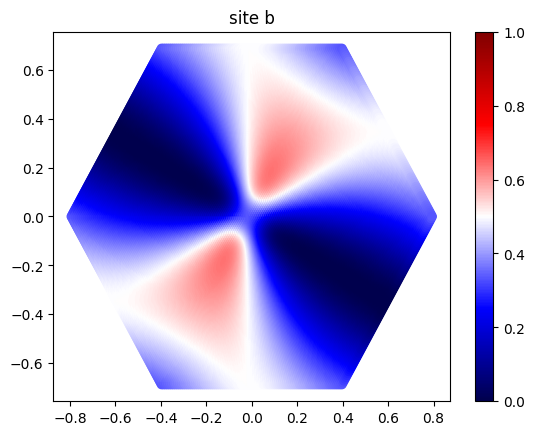

In [36]:
plt.figure()
plt.scatter(point_all[:, 0], point_all[:, 1], c=site_distribution[:,1],cmap = 'seismic', vmin=0, vmax=1)
plt.colorbar()
plt.title('site b')

Text(0.5, 1.0, 'site c')

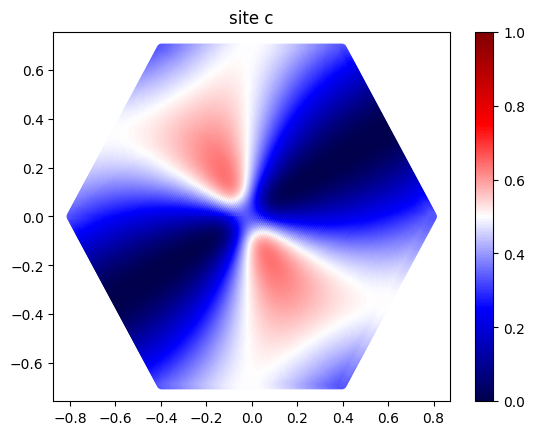

In [37]:
plt.figure()
plt.scatter(point_all[:, 0], point_all[:, 1], c=site_distribution[:,2],cmap = 'seismic', vmin=0, vmax=1)
plt.colorbar()
plt.title('site c')

Text(0.5, 1.0, 'site c')

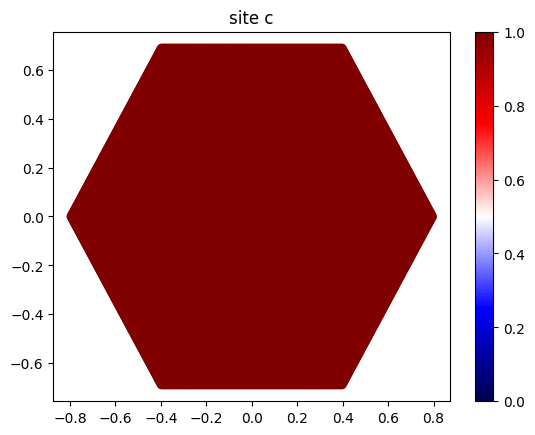

In [38]:
plt.figure()
plt.scatter(point_all[:, 0], point_all[:, 1], c=np.sum(site_distribution,axis=1),cmap = 'seismic', vmin=0, vmax=1)
plt.colorbar()
plt.title('site c')

### DOS

In [39]:
# prepare the initial mean-field terms
from functions_parameters.universal_parameters import k_mesh_points


h_mean_u_o = dict_ref_ref['h_mean_u']
h_mean_v_o = dict_ref_ref['h_mean_v']
h_mean_initial_u_o = h_mean_u_o*u_input
h_mean_initial_o = h_mean_initial_u_o[None, :, :, :] + np.einsum('Nsvmn,v->Nsmn', h_mean_v_o,v_arr)

# prepare the input mean-field terms
h_mean_input_u_o = mean_field_u(input_d, u_input)
h_mean_input_v_o_o = hartree_spinor(a_lists, v_arr, input_d)
h_mean_input_o_o = h_mean_input_u_o + h_mean_input_v_o_o
# k-dependent part
h_mean_input_v_k_o = fock_spinor(input_bond, v_arr, phase_pos)
h_mean_input_o = h_mean_input_o_o[None, :, :, :] + h_mean_input_v_k_o

e_tot = np.zeros((k_mesh_points.shape[0], 6))
e_tot_o = np.zeros((k_mesh_points.shape[0], 3))
for i in range(k_mesh_points.shape[0]):
    e_o,v_o = la.eigh(Htb[i])
    e_tot_o[i,:] = e_o
    hup = Htb[i] + h_mean_input_o[i,0] - h_mean_initial_o[i,0]
    e_up,v_up = la.eigh(hup)
    hdn = Htb[i] + h_mean_input_o[i,1] - h_mean_initial_o[i,1]
    e_dn,v_dn = la.eigh(hdn)
    e_tot[i,:] = np.concatenate((e_up, e_dn))

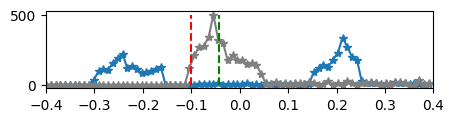

In [40]:
num_bins = 81
hist, bin_edges = np.histogram(e_tot, num_bins, (-0.4,0.4), density=False)
hist_o, bin_edges_o = np.histogram(e_tot_o, num_bins, (-0.4,0.4), density=False)
plt.figure(figsize=(5, 1))
plt.plot(bin_edges[:-1], hist/2,'*-')
plt.plot(bin_edges_o[:-1], hist_o,'*-',color='grey')
plt.vlines(dict_ref_ref['e_fermi'], 0, np.max(hist_o), colors='green', linestyles='--')
plt.vlines(sorted_e_fermi[filling_index, u_index,0], 0, np.max(hist_o), colors='red', linestyles='--')
plt.xlim(-0.4,0.4)
plt.show()

# a better phase diagram

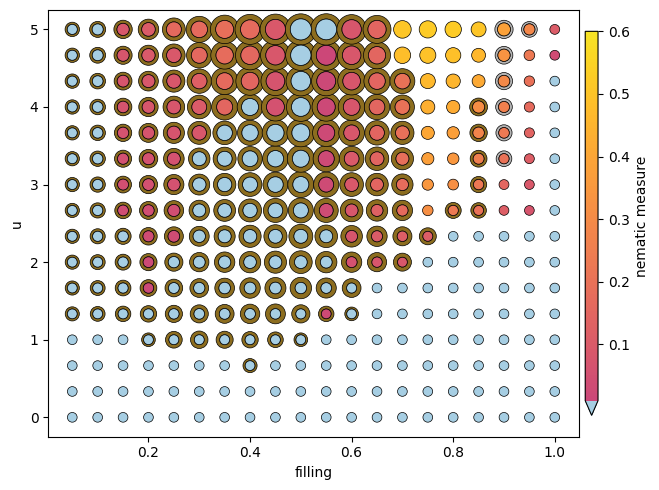

In [41]:
from functions_parameters.phase_plot import PlotConfig, plot_phase_map

ts_check = np.zeros(u_mesh.shape)
CFG = PlotConfig(nem_vmax=0.6, energy_max=0.1)
fig, ax = plt.subplots(figsize=(7, 5))
plot_phase_map(
    fig,
    ax,
    filling_mesh/2, u_mesh/0.15,
    sorted_ground_state_e,               # [...,0] read inside
    nematic_measure,
    ts_check, f_phase,
    f_max_measure,                       # or f_measure if you prefer mean
    cfg=CFG,
)
# ax.set_box_aspect(1)
ax.set_xlabel("filling")
ax.set_ylabel("u")
plt.tight_layout(); plt.show()

In [42]:
np.min(sorted_ground_state_e)

np.float64(-0.0900613597928567)

In [43]:
sorted_ground_state_e[9,-1,0]

np.float64(-0.0900613597928567)

In [44]:
sorted_density[9,-12,0]

array([[0.28440774+1.03663631e-25j, 0.28440774-9.16140833e-20j,
        0.28440774-7.75370031e-20j],
       [0.04892559-1.21042577e-26j, 0.04892559+1.63983469e-20j,
        0.04892559+2.48664496e-20j]])

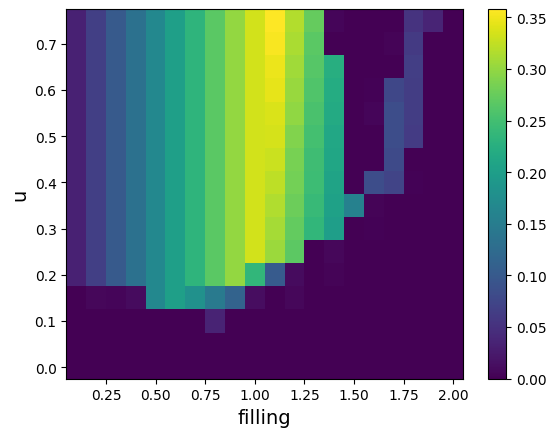

In [45]:
plt.pcolormesh(filling_mesh, u_mesh, f_measure)
plt.colorbar()
plt.xlabel('filling', size = '14')
plt.ylabel('u', size = '14')
plt.show()

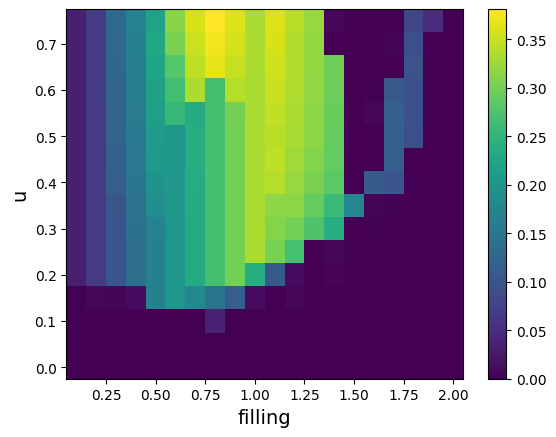

In [46]:
plt.pcolormesh(filling_mesh, u_mesh, f_max_measure)
plt.colorbar()
plt.xlabel('filling', size = '14')
plt.ylabel('u', size = '14')
plt.show()

In [47]:
np.max(f_max_measure)

np.float64(0.38098362751597453)

In [48]:
np.where(f_max_measure==np.max(f_max_measure))

(array([7]), array([15]))

In [49]:
np.max(nematic_measure)

np.float64(0.5232027392900163)

# check the degeneracy

In [50]:
# first find if there are energy states that are highly degenerate as the known ground state while in the different phase
states_index = np.where(np.logical_and(sorted_ground_state_e - sorted_ground_state_e[:,:,0][:,:,np.newaxis]<1E-4, sorted_ground_state_e - sorted_ground_state_e[:,:,0][:,:,np.newaxis]>1E-7))
# then find out the states that are in a different phase than the known ground state
states_index_len = len(states_index[0])
degenerate_state_diagram = -np.ones(final_c_difference.shape, dtype=np.int32)
for index in range(states_index_len):
    i = states_index[0][index]
    j = states_index[1][index]
    k = states_index[2][index]
    d_ij = sorted_density[i,j,k]
    rs_recording, m_recording, c6_diff, magnetism_arr = phase_check_nematic_magnetic(d_ij, c_6_uc, c_3_uc, c_2_uc)
    phase_arr = np.kron(rs_recording,m_recording)
    phase = np.argmax(phase_arr)
    if phase != phase_diagram_based_on_d[i,j] and phase not in degenerate_state_diagram[i,j]:
        degenerate_state_diagram[i,j,k]=phase

In [51]:
degenerate_index = np.where(degenerate_state_diagram>0)

In [52]:
degenerate_index

(array([ 1,  2,  3,  3,  4,  8, 10, 10, 11, 12, 15, 15, 16, 18, 18, 19, 19]),
 array([13,  8,  5,  6,  7, 12,  4, 14,  6,  5,  7,  9, 12,  7, 15, 10, 11]),
 array([4, 3, 6, 6, 5, 5, 4, 6, 6, 3, 3, 3, 6, 4, 3, 6, 7]))

In [53]:
unique_phase_index_degenerate = np.unique(degenerate_state_diagram)
unique_phase_name_degenerate = [phase_1_1[i] for i in np.int_(unique_phase_index_degenerate) if i != -1]

In [54]:
unique_phase_name_degenerate

[' R symmetric +',
 ' R symmetric FM',
 ' C2 charge nematic +',
 ' C2 charge nematic FM']

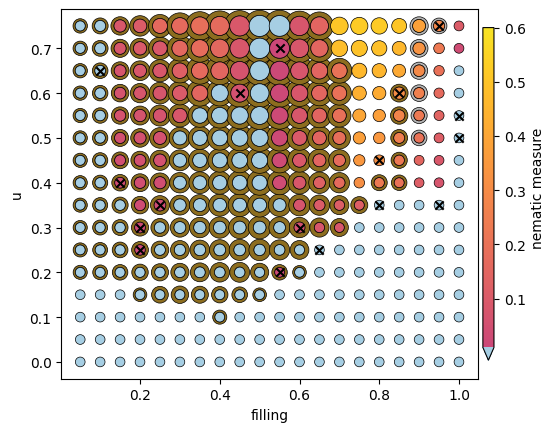

In [55]:
fig, ax = plt.subplots()
plot_phase_map(
    fig,
    ax,
    filling_mesh/2, u_mesh,
    sorted_ground_state_e,               # [...,0] read inside
    nematic_measure,
    ts_check, f_phase,
    f_max_measure,                       # or f_measure if you prefer mean
    cfg=CFG,
)
ax.set_xlabel("filling")
ax.set_ylabel("u")
ax.scatter(filling_arr[degenerate_index[0]]/2, u_arr[degenerate_index[1]], marker='x', color='black', zorder=10)

In [56]:
sorted_density[4,-1,0]

array([[2.20154210e-01-9.26685380e-25j, 5.96918363e-02+1.73161149e-20j,
        2.20153955e-01-6.49122123e-20j],
       [8.75651076e-27+1.47908373e-50j, 8.75651076e-27-1.91026560e-45j,
        8.75651076e-27+2.55117597e-45j]])

In [57]:
np.max(nematic_measure)

np.float64(0.5232027392900163)

In [58]:
np.where(nematic_measure==np.max(nematic_measure))

(array([15]), array([15]))

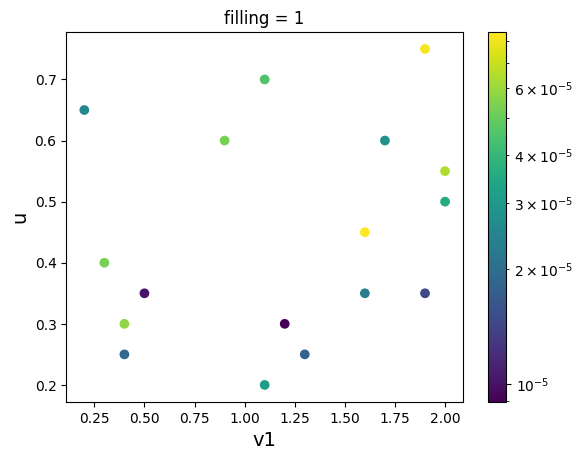

In [59]:
import matplotlib

plt.scatter(filling_arr[degenerate_index[0]], u_arr[degenerate_index[1]], c=sorted_ground_state_e[degenerate_index]-sorted_ground_state_e[degenerate_index[0],degenerate_index[1],0],zorder=10,marker='o',cmap='viridis',norm=matplotlib.colors.LogNorm())
plt.colorbar()
plt.xlabel('v1', size = '14')
plt.ylabel('u', size = '14')
plt.title('filling = 1')
plt.show()

In [66]:
from functions_parameters.phase_plot import rect_marker

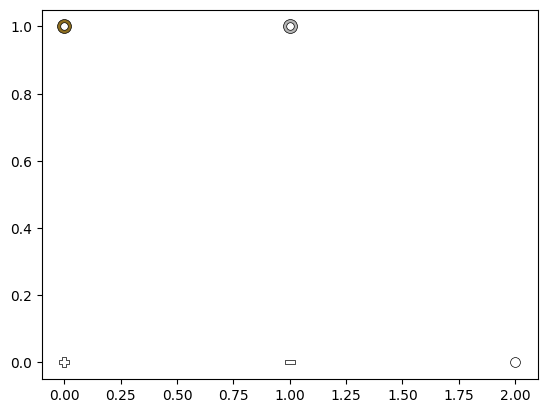

In [76]:
fig, ax = plt.subplots()
ax.scatter(0,0,marker='P',zorder=10,c='#FFFFFF',edgecolors='black',s=50,linewidths=0.5)
ax.scatter(1,0,marker=rect_marker(),zorder=10,c='#FFFFFF',edgecolors='black',s=50,linewidths=0.5)
ax.scatter(2,0,marker='o',zorder=10,c='#FFFFFF',edgecolors='black',s=50,linewidths=0.5)
ax.scatter(0,1,marker='o',zorder=10,c=CFG.color_fm,edgecolors='black',s=100,linewidths=0.5)
ax.scatter(0,1,marker='o',zorder=10.1,c='#FFFFFF',edgecolors='black',s=30,linewidths=0.5)
ax.scatter(1,1,marker='o',zorder=10,c=CFG.color_ferri_afm,edgecolors='black',s=100,linewidths=0.5)
ax.scatter(1,1,marker='o',zorder=10.1,c='#FFFFFF',edgecolors='black',s=30,linewidths=0.5)
fig.savefig('markers.pdf',dpi=600)
